# Initialisation

In [3]:
%%capture
!pip install rpy2==3.5.1 # Utiliser cette version pour éviter un bug
!pip install pyreadr
!pip install auto-sklearn

In [5]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_hist_gradient_boosting # Pour autoriser l'import de HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv # Pour autoriser l'import de HalvingGridSearchCV
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.notebook import tqdm
from random import randrange
from autosklearn.classification import AutoSklearnClassifier

sns.set_style("white")

Télécharger les fichiers du dataset

In [ ]:
%%capture
!wget -O datagotchi_dataset.rds https://www.dropbox.com/s/clngl24sya61z17/data-hub-clean-2022-10-27_clean.rds?dl=0
!wget -O datagotchi_dataset_targets.csv https://www.dropbox.com/s/e2xcqdzhhwtvbtn/data-hub-clean-2022-12-06_clean_with_party_winners_by_ridings.csv?dl=0

Lire les fichiers du dataset

In [ ]:
pandas2ri.activate()
readRDS = robjects.r['readRDS']
df = readRDS('/content/datagotchi_dataset.rds')
df = pandas2ri.rpy2py_dataframe(df)

df_targets = pd.read_csv('datagotchi_dataset_targets.csv', sep=',', encoding='latin-1')

# Prétraitement des données

Créer les targets à partir de people_predict

In [ ]:
targets = []
for i in tqdm(range(len(df_targets)), leave=False):
  row = df_targets.iloc[i]
  targets.append(int(row['people_predict'] == row['riding_party_winner']))
df['correct_prediction'] = targets
del df_targets

Retrait des données où people_predict est NaN (en enlevant les targets correspondants), et retirer people_predict

In [7]:
index_nan = df['people_predict'][df['people_predict'] < 0].index
df.drop(index=index_nan, inplace=True)

df.drop(columns='people_predict', inplace=True)

Retrait de colonnes redondants et/ou inutiles

In [8]:
colonnes_a_retirer = [
    'id',
    'film_title',
    'vote_pred',
    'time',
    'people_pred_CAQ',
    'people_pred_PQ',
    'people_pred_PLQ',
    'people_pred_QS',
    'people_pred_PCQ',
    'vote_pred_CAQ',
    'vote_pred_PQ',
    'vote_pred_PLQ',
    'vote_pred_QS',
    'vote_pred_PCQ',
    'op_intent',
    'health_relation_entourage',
    'health_stay_home',
    'health_physical_health',
    'health_time_nature',
    'health_mental_health',
    'age34m', 'age3554', 'age55p',
    'mrc_name',
    'educBHS', 'educCollege', 'educUniv',
    'artist_name',
    'postal_code',
    ]
df.drop(columns=colonnes_a_retirer, inplace=True)

Retrait des données où l'âge n'est pas légale ou vraisemblable

In [9]:
idx_list = []
for idx, row in df.iterrows():
  if row['age'] < 18 or row['age'] > 80:
    idx_list.append(idx)
df.drop(index=idx_list, inplace=True)

Conversion de plusieurs colonnes cons_Smoke one-hot en une seule à float

In [10]:
colonnes_Smoke = [
    'cons_Smoke_never',
    'cons_Smoke_few_times_year',
    'cons_Smoke_month',
    'cons_Smoke_once_week',
    'cons_Smoke_few_times_week',
    'cons_Smoke_once_day',
    'cons_Smoke_few_times_day'
    ]

cons_Smoke = []
for idx, row in df.iterrows():
  if row[colonnes_Smoke[0]]:
    cons_Smoke.append(0)
  elif row[colonnes_Smoke[1]]:
    cons_Smoke.append(0.167)
  elif row[colonnes_Smoke[2]]:
    cons_Smoke.append(0.334)
  elif row[colonnes_Smoke[3]]:
    cons_Smoke.append(0.5)
  elif row[colonnes_Smoke[4]]:
    cons_Smoke.append(0.667)
  elif row[colonnes_Smoke[5]]:
    cons_Smoke.append(0.834)
  elif row[colonnes_Smoke[6]]:
    cons_Smoke.append(1)
  else:
    cons_Smoke.append(np.nan)

df['cons_Smoke'] = cons_Smoke
df.drop(columns=colonnes_Smoke, inplace=True)

Conversion de plusieurs colonnes cons_meat one-hot en une seule à float

In [11]:
colonnes_meat = [
    'cons_meat_never',
    'cons_meat_almost_never',
    'cons_meat_once_month',
    'cons_meat_once_week',
    'cons_meat_few_week',
    'cons_meat_daily',
    'cons_meat_few_daily'
    ]

cons_meat = []
for idx, row in df.iterrows():
  if row[colonnes_meat[0]]:
    cons_meat.append(0)
  elif row[colonnes_meat[1]]:
    cons_meat.append(0.167)
  elif row[colonnes_meat[2]]:
    cons_meat.append(0.334)
  elif row[colonnes_meat[3]]:
    cons_meat.append(0.5)
  elif row[colonnes_meat[4]]:
    cons_meat.append(0.667)
  elif row[colonnes_meat[5]]:
    cons_meat.append(0.834)
  elif row[colonnes_meat[6]]:
    cons_meat.append(1)
  else:
    cons_meat.append(np.nan)

df['cons_meat'] = cons_meat
df.drop(columns=colonnes_meat, inplace=True)

Conversion de plusieurs colonnes ses_income one-hot en une seule à float

In [12]:
colonnes_income = [
    'ses_income_None',
    'ses_income_i1to30',
    'ses_income_i31to60',
    'ses_income_i61to90',
    'ses_income_i91to110',
    'ses_income_i111to150',
    'ses_income_i151to200',
    'ses_income_i201toInf'
    ]

ses_income = []
for idx, row in df.iterrows():
  if row[colonnes_income[0]]:
    ses_income.append(0)
  elif row[colonnes_income[1]]:
    ses_income.append(0.143)
  elif row[colonnes_income[2]]:
    ses_income.append(0.286)
  elif row[colonnes_income[3]]:
    ses_income.append(0.423)
  elif row[colonnes_income[4]]:
    ses_income.append(0.571)
  elif row[colonnes_income[5]]:
    ses_income.append(0.714)
  elif row[colonnes_income[6]]:
    ses_income.append(0.857)
  elif row[colonnes_income[7]]:
    ses_income.append(1)
  else:
    ses_income.append(np.nan)

df['ses_income'] = ses_income
df.drop(columns=colonnes_income, inplace=True)

Conversion de plusieurs colonnes ses_educ one-hot en une seule à float

In [13]:
colonnes_educ = [
    'ses_educ_None',
    'ses_educ_Prim',
    'ses_educ_Sec',
    'ses_educ_Coll',
    'ses_educ_Bacc',
    'ses_educ_Master',
    'ses_educ_PhD'
    ]

ses_educ = []
for idx, row in df.iterrows():
  if row[colonnes_educ[0]]:
    ses_educ.append(0)
  elif row[colonnes_educ[1]]:
    ses_educ.append(0.167)
  elif row[colonnes_educ[2]]:
    ses_educ.append(0.334)
  elif row[colonnes_educ[3]]:
    ses_educ.append(0.5)
  elif row[colonnes_educ[4]]:
    ses_educ.append(0.667)
  elif row[colonnes_educ[5]]:
    ses_educ.append(0.834)
  elif row[colonnes_educ[6]]:
    ses_educ.append(1)
  else:
    ses_educ.append(np.nan)
    
df['ses_educ'] = ses_educ
df.drop(columns=colonnes_educ, inplace=True)

Remplacement des valeurs NaN de voting_probability par la valeur moyenne

In [14]:
mean_voting_probability = df['voting_probability'].mean()
df['voting_probability'] = df['voting_probability'].fillna(mean_voting_probability)

Retrait des données ayant des valeurs NaN des les colonnes op_intent

In [15]:
index_nan = df['op_intent_CAQ'][df['op_intent_CAQ'].isna()].index # Toutes les données correspondantes ont NaN dans op_intent_CAQ
df.drop(index=index_nan, inplace=True)

Obtenir des one-hot vectors pour les colonnes de strings restants

In [16]:
df = pd.get_dummies(df)

Méthode 1 pour gérer les NaN restants : retirer les données qui les contiennent

In [17]:
df_met1 = df.copy(deep=True)

idx_a_enlever = []
for idx, row in df_met1.iterrows():
  if row.isna().values.any():
    idx_a_enlever.append(idx)
df_met1.drop(index=idx_a_enlever, inplace=True)

Méthode 2 pour gérer les NaN restants : remplacer les NaN par d'autres données du jeu (permet de conserver les ratios préexistants)

In [ ]:
df_met2 = df.copy(deep=True)
df_met2.reset_index(drop=True, inplace=True)

isna_idx = df_met2[df_met2['music_genre_rock'].isna()].index
notna_idx = df_met2[df_met2['music_genre_rock'].notna()].index
for idx_to_replace in tqdm(isna_idx, leave=False):
  idx_to_replace = int(idx_to_replace)
  idx_to_copy = int(notna_idx[randrange(len(notna_idx))])
  df_met2.iloc[idx_to_replace, list(range(22,43))] = df_met2.iloc[idx_to_copy, list(range(22,43))] # 22 à 42 correspondent aux colonnes music_genre_(type)

isna_idx = df_met2[df_met2['film_Action'].isna()].index
notna_idx = df_met2[df_met2['film_Action'].notna()].index
for idx_to_replace in tqdm(isna_idx, leave=False):
  idx_to_replace = int(idx_to_replace)
  idx_to_copy = int(notna_idx[randrange(len(notna_idx))])
  df_met2.iloc[idx_to_replace, list(range(43,63))] = df_met2.iloc[idx_to_copy, list(range(43,63))] # 43 à 62 correspondent aux colonnes film_(type)

Méthode 3 pour gérer les NaN restants : retirer les colonnes qui les contiennent

In [ ]:
df_met3 = df.copy(deep=True)

df_met3.drop(columns=df_met3.columns[list(range(22,63))], inplace=True) # 22 à 63 correspondent aux colonnes music_genre_(type) et film_(type)

# Recherche d'hyperparamètres

On utilise auto-sklearn pour s'inspirer des résultats pour le prétraitement et les modèles à utiliser

In [18]:
# df_met1
X, y = df_met1.drop(columns='correct_prediction'), df_met1['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)
automl1 = AutoSklearnClassifier(time_left_for_this_task=1800)
automl1.fit(X_train, y_train)
print(f'Accuracy score: {accuracy_score(y_test, automl1.predict(X_test))}')

In [ ]:
# df_met2
X, y = df_met2.drop(columns='correct_prediction'), df_met2['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)
automl2 = AutoSklearnClassifier(time_left_for_this_task=1800)
automl2.fit(X_train, y_train)
print(f'Accuracy score: {accuracy_score(y_test, automl2.predict(X_test))}')

In [ ]:
# df_met3
X, y = df_met3.drop(columns='correct_prediction'), df_met3['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)
automl3 = AutoSklearnClassifier(time_left_for_this_task=1800)
automl3.fit(X_train, y_train)
print(f'Accuracy score: {accuracy_score(y_test, automl3.predict(X_test))}')

Puisque automl1 performe mieux en accuracy score sur le test set, nous prenons df_met1 et les modèles les plus prometteurs d'automl1 pour la suite

In [19]:
df = df_met1.copy(deep=True)
del df_met1, df_met2, df_met3

In [ ]:
pd.DataFrame(automl1.show_models().values()).head(10)

,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
0,2,1,0.214983,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=19, rando..."
1,3,2,0.212264,0.30,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
2,9,3,0.231178,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
3,11,4,0.221535,0.10,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
4,14,5,0.241686,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"LinearDiscriminantAnalysis(shrinkage='auto', s..."
5,15,6,0.283101,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"MLPClassifier(alpha=0.0017940473175767063, bet..."
6,17,7,0.215849,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(ExtraTreeClassifier(criterion='entropy', max_..."
7,21,8,0.211769,0.28,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
8,23,9,0.242304,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,HistGradientBoostingClassifier(early_stopping=...
9,29,10,0.212016,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(ExtraTreeClassifier(criterion='entropy', max_..."


On vérifie la performance en test et la matrice de confusion avec un modèle d'autosklearn pour vérifier s'il y a une disparité des prédictions de classe

In [ ]:
X, y = df.drop(columns='correct_prediction'), df['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)

In [ ]:
score = 0
for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
  rfc = RandomForestClassifier(max_depth=34, max_features='sqrt', n_estimators=352, random_state=1, class_weight='balanced').fit(X_train, y_train)
  score += rfc.score(X_test, y_test) / 3
  if i == 0:
    cf_matrix = confusion_matrix(y_test, rfc.predict(X_test)) / 3
  else:
    cf_matrix += confusion_matrix(y_test, rfc.predict(X_test)) / 3
print(f'Accuracy score: {round(score,3)}')
print(f'TN: {int(cf_matrix[0,0])} ; FN: {int(cf_matrix[1,0])} ; TP: {int(cf_matrix[1,1])} ; FP: {int(cf_matrix[0,1])}')

Accuracy score: 0.782
TN: 710 ; FN: 343 ; TP: 7277 ; FP: 1882


Puisque il y a une grande imbalance de prédictions de classe (89% des prédictions sont pour classe 1, lorsque le ratio de classe 1 dans le jeu de données est de 75%), des données de classe 1 seront retirées pour balancer les classes

In [ ]:
df.sort_values(by='correct_prediction', inplace=True)
nb_0 = len(df[df['correct_prediction'] == 0].index)
df = df.iloc[:2*nb_0]

On revérifie la performance en test et la matrice de confusion avec le nouveau balancement

In [ ]:
X, y = df.drop(columns='correct_prediction'), df['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)

In [ ]:
score = 0
for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
  rfc = RandomForestClassifier(max_depth=34, max_features='sqrt', n_estimators=352, random_state=1, class_weight='balanced').fit(X_train, y_train)
  score += rfc.score(X_test, y_test) / 3
  if i == 0:
    cf_matrix = confusion_matrix(y_test, rfc.predict(X_test)) / 3
  else:
    cf_matrix += confusion_matrix(y_test, rfc.predict(X_test)) / 3
print(f'Accuracy score: {round(score,3)}')
print(f'TN: {int(cf_matrix[0,0])} ; FN: {int(cf_matrix[1,0])} ; TP: {int(cf_matrix[1,1])} ; FP: {int(cf_matrix[0,1])}')

Accuracy score: 0.725
TN: 1803 ; FN: 635 ; TP: 1957 ; FP: 789


La performance est moins bonne, mais le modèle généralise mieux puisqu'il n'y a plus le biais d'imbalance

Recherche en grille pour RandomForestClassifier avec HalvingGridSearchCV

In [ ]:
X, y = df.drop(columns='correct_prediction'), df['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)

In [ ]:
# RandomForestClassifier
rfc = RandomForestClassifier(random_state=1)
rfc_grid = {
    'n_estimators': list(range(64, 769, 32)),
    'max_depth': list(range(2, 65, 2)) + [None],
    'max_features': ['sqrt', 'log2', None]
}
rfc_search = HalvingGridSearchCV(rfc, rfc_grid, cv=3, verbose=1).fit(X_train, y_train)
print('RandomForestClassifier:')
print(f'\tBest params: {rfc_search.best_params_}')
print(f'\tScore with best params: {rfc_search.score(X_test, y_test)}')

n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 12
max_resources_: 12444
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2277
n_resources: 12
Fitting 3 folds for each of 2277 candidates, totalling 6831 fits
----------
iter: 1
n_candidates: 759
n_resources: 36
Fitting 3 folds for each of 759 candidates, totalling 2277 fits
----------
iter: 2
n_candidates: 253
n_resources: 108
Fitting 3 folds for each of 253 candidates, totalling 759 fits
----------
iter: 3
n_candidates: 85
n_resources: 324
Fitting 3 folds for each of 85 candidates, totalling 255 fits
----------
iter: 4
n_candidates: 29
n_resources: 972
Fitting 3 folds for each of 29 candidates, totalling 87 fits
----------
iter: 5
n_candidates: 10
n_resources: 2916
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 4
n_resources: 8748
Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForestClassifier:
	Best params: {'max

On vérifie la performance en test et la matrice de confusion avec le meilleur modèle de RandomForestClassifier

In [ ]:
score = 0
for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
  rfc = RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=544, random_state=1).fit(X_train, y_train)
  score += rfc.score(X_test, y_test) / 3
  if i == 0:
    cf_matrix = confusion_matrix(y_test, rfc.predict(X_test)) / 3
  else:
    cf_matrix += confusion_matrix(y_test, rfc.predict(X_test)) / 3
print(f'Accuracy score: {round(score,3)}')
print(f'TN: {int(cf_matrix[0,0])} ; FN: {int(cf_matrix[1,0])} ; TP: {int(cf_matrix[1,1])} ; FP: {int(cf_matrix[0,1])}')

Accuracy score: 0.723
TN: 1750 ; FN: 594 ; TP: 1998 ; FP: 842


Recherche en grille pour ExtraTreesClassifier avec HalvingGridSearchCV

In [ ]:
X, y = df.drop(columns='correct_prediction'), df['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)

In [ ]:
etc = ExtraTreesClassifier(random_state=1)
etc_grid = {
    'n_estimators': list(range(64, 769, 32)),
    'max_depth': list(range(2, 65, 2)) + [None],
    'max_features': ['sqrt', 'log2', None]
}
etc_search = HalvingGridSearchCV(etc, etc_grid, cv=3, verbose=1).fit(X_train, y_train)
print('ExtraTreesClassifier:')
print(f'\tBest params: {etc_search.best_params_}')
print(f'\tScore with best params: {etc_search.score(X_test, y_test)}')

n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 12
max_resources_: 12444
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2277
n_resources: 12
Fitting 3 folds for each of 2277 candidates, totalling 6831 fits
----------
iter: 1
n_candidates: 759
n_resources: 36
Fitting 3 folds for each of 759 candidates, totalling 2277 fits
----------
iter: 2
n_candidates: 253
n_resources: 108
Fitting 3 folds for each of 253 candidates, totalling 759 fits
----------
iter: 3
n_candidates: 85
n_resources: 324
Fitting 3 folds for each of 85 candidates, totalling 255 fits
----------
iter: 4
n_candidates: 29
n_resources: 972
Fitting 3 folds for each of 29 candidates, totalling 87 fits
----------
iter: 5
n_candidates: 10
n_resources: 2916
Fitting 3 folds for each of 10 candidates, totalling 30 fits
----------
iter: 6
n_candidates: 4
n_resources: 8748
Fitting 3 folds for each of 4 candidates, totalling 12 fits
ExtraTreesClassifier:
	Best params: {'max_d

On vérifie la performance en test et la matrice de confusion avec le meilleur modèle de ExtraTreesClassifier

In [ ]:
score = 0
for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
  etc = ExtraTreesClassifier(max_depth=54, max_features=None, n_estimators=768, random_state=1).fit(X_train, y_train)
  score += etc.score(X_test, y_test) / 3
  if i == 0:
    cf_matrix = confusion_matrix(y_test, etc.predict(X_test)) / 3
  else:
    cf_matrix += confusion_matrix(y_test, etc.predict(X_test)) / 3
print(f'Accuracy score: {round(score,3)}')
print(f'TN: {int(cf_matrix[0,0])} ; FN: {int(cf_matrix[1,0])} ; TP: {int(cf_matrix[1,1])} ; FP: {int(cf_matrix[0,1])}')

In [ ]:
X, y = df.drop(columns='correct_prediction'), df['correct_prediction']
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=1, shuffle=True, train_size=0.8)

In [ ]:
# Auto-sklearn avec HistGradientBoostingClassifier
automl1 = AutoSklearnClassifier(time_left_for_this_task=10800, include={'classifier': ['gradient_boosting']})
automl1.fit(X_train, y_train)
print(f'Accuracy score: {accuracy_score(y_test, automl1.predict(X_test))}')

Accuracy score: 0.7239717223650386


In [ ]:
print(automl1.show_models().values())

dict_values([{'model_id': 2, 'rank': 1, 'cost': 0.28000973946919894, 'ensemble_weight': 0.06, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f004bdd53d0>, 'balancing': Balancing(random_state=1), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f0049d8b9a0>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f0049d8b8b0>, 'sklearn_classifier': HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1e-10,
                               max_iter=512, n_iter_no_change=0, random_state=1,
                               validation_fraction=None, warm_start=True)}, {'model_id': 10, 'rank': 2, 'cost': 0.2785488190893596, 'ensemble_weight': 0.04, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f0049eefa90>, 'balancing': Balancing(random_state=1), 'fea

On vérifie la performance en test et la matrice de confusion avec le meilleur modèle de HistGradientBoostingClassifier

In [ ]:
score = 0
for i, (train_idx, test_idx) in enumerate(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X, y)):
  X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
  hgbc = HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1e-10, max_iter=512, n_iter_no_change=0, random_state=1, validation_fraction=None, warm_start=True).fit(X_train, y_train)
  score += hgbc.score(X_test, y_test) / 3
  if i == 0:
    cf_matrix = confusion_matrix(y_test, hgbc.predict(X_test)) / 3
  else:
    cf_matrix += confusion_matrix(y_test, hgbc.predict(X_test)) / 3
print(f'Accuracy score: {round(score,3)}')
print(f'TN: {int(cf_matrix[0,0])} ; FN: {int(cf_matrix[1,0])} ; TP: {int(cf_matrix[1,1])} ; FP: {int(cf_matrix[0,1])}')

Accuracy score: 0.717
TN: 1817 ; FN: 692 ; TP: 1900 ; FP: 775


Recherche en grille pour HistGradientBoostingClassifier avec HalvingGridSearchCV (par souci de temps, nous sommes passés par auto-sklearn au lieu de rouler cette recherche)

In [ ]:
hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc_grid = {
    'learning_rate': np.arange(0.01, 0.21, 0.01),
    'max_iter': list(range(64, 1025, 64)),
    'max_leaf_nodes': list(range(16, 64, 4)),
    'validation_fraction': [None]
}
hgbc_search = HalvingGridSearchCV(hgbc, hgbc_grid, cv=3, verbose=1).fit(X_train, y_train)
print('HistGradientBoostingClassifier:')
print(f'\tBest params: {hgbc_search.best_params_}')
print(f'\tScore with best params: {hgbc_search.score(X_test, y_test)}')

# Graphiques

### Informations statistiques

Bonnes prédictions par rapport à people_predict

In [ ]:
caq_ratio = df.loc[df['people_predict'] == 'CAQ']

### Pour quel parti voteriez-vous s’il y avait une élection provinciale québécoise aujourd’hui?

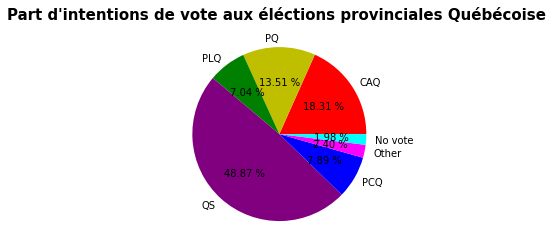

In [ ]:
caq = df.loc[df['op_intent_CAQ'] == 1].count()[0]
pq = df.loc[df['op_intent_PQ'] == 1].count()[0]
plq = df.loc[df['op_intent_PLQ'] == 1].count()[0]
qs = df.loc[df['op_intent_QS'] == 1].count()[0]
pcq = df.loc[df['op_intent_PCQ'] == 1].count()[0]
other = df.loc[df['op_intent_Other'] == 1].count()[0]
no = df.loc[df['op_intent_no_vote'] == 1].count()[0]


labels = ["CAQ","PQ","PLQ", "QS", "PCQ", "Other", "No vote"]
colors = ["red","y","green","purple","blue","magenta","cyan","#abcdef"]
plt.pie([caq,pq,plq,qs,pcq,other,no], labels = labels, colors=colors, autopct = "%.2f %%")
plt.title("Part d'intentions de vote aux éléctions provinciales Québécoise ",fontdict = {'fontweight':'bold','fontsize':'15'})

plt.show()

### Prédiction de votes des citoyens

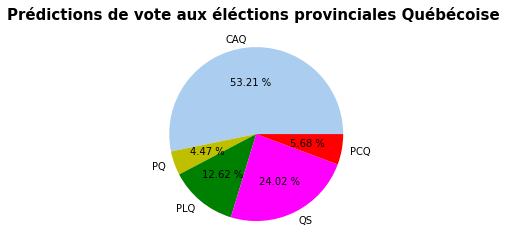

In [ ]:
caq = df.loc[df['people_pred_CAQ'] == 1].count()[0]
pq = df.loc[df['people_pred_PQ'] == 1].count()[0]
plq = df.loc[df['people_pred_PLQ'] == 1].count()[0]
qs = df.loc[df['people_pred_QS'] == 1].count()[0]
pcq = df.loc[df['people_pred_PCQ'] == 1].count()[0]



labels = ["CAQ","PQ","PLQ", "QS", "PCQ"]
colors = ["#abcdef","y","green","magenta","red"]
plt.pie([caq,pq,plq,qs,pcq], labels = labels, colors=colors, autopct = "%.2f %%")
plt.title("Prédictions de vote aux éléctions provinciales Québécoise ",fontdict = {'fontweight':'bold','fontsize':'15'})

plt.show()



### Proportion d'hommes et de femmes

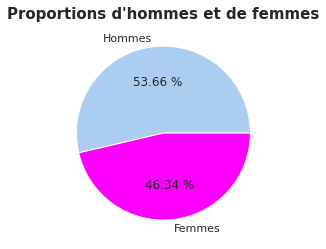

In [ ]:
men = df.loc[df['male'] == 1].count()[0]
women = df.loc[df['female'] == 1].count()[0]

labels = ["Hommes", "Femmes"]
colors = ["#abcdef","magenta"]
plt.pie([men,women], labels = labels, colors=colors, autopct = "%.2f %%")
plt.title("Proportions d'hommes et de femmes",fontdict = {'fontweight':'bold','fontsize':'15'})

plt.show()

### Age des votants

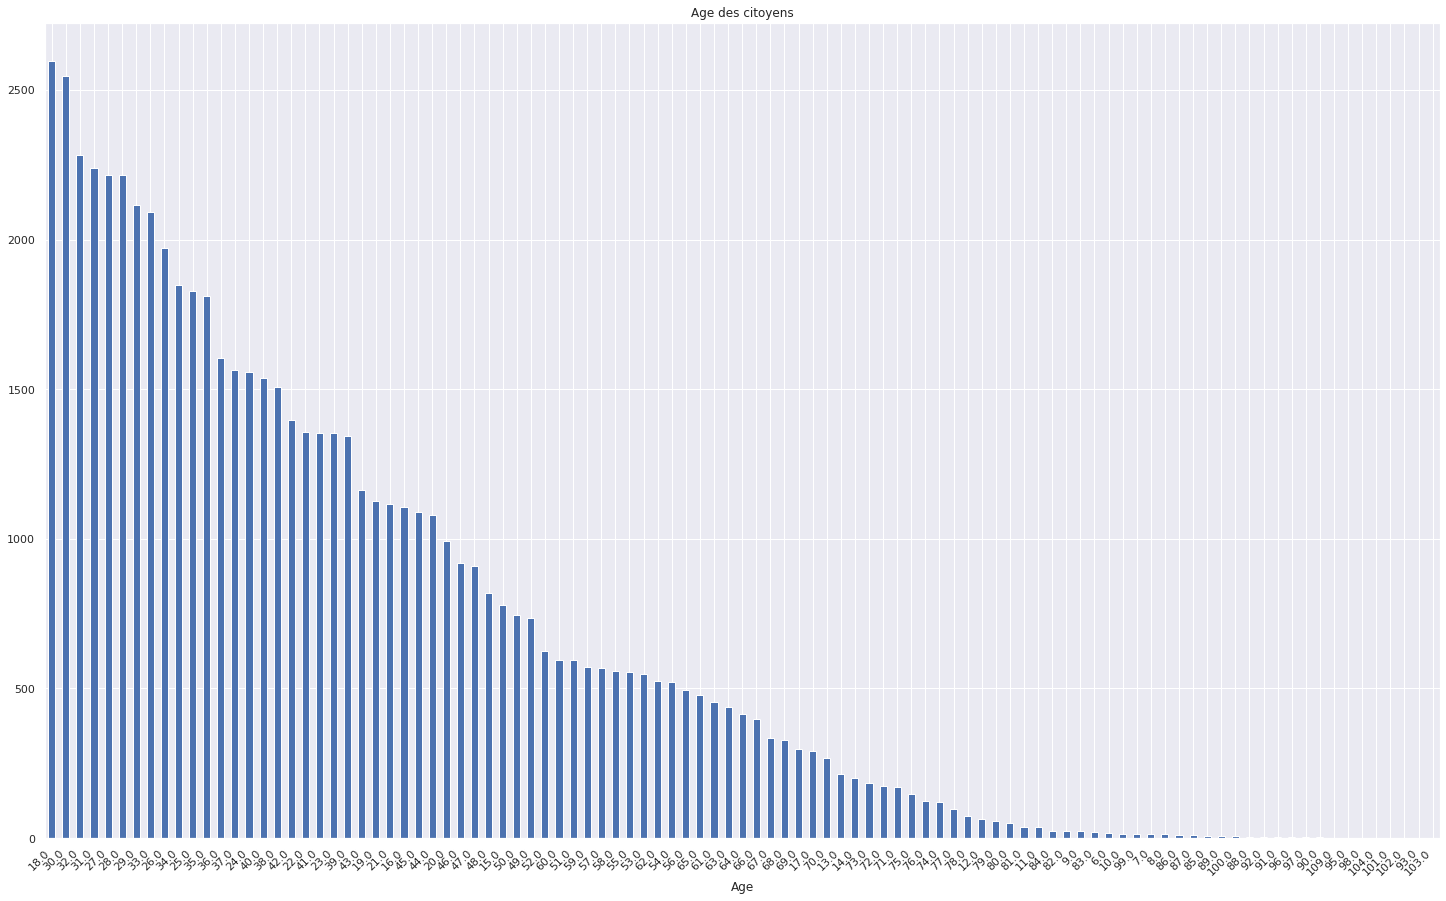

In [ ]:
df['age'].value_counts().plot(kind='bar',orientation=u'vertical',figsize=(25,15),title="Age des citoyens",xlabel="Age")
plt.xticks(rotation=45, ha='right')
plt.grid(color='w', linestyle='solid')
plt.show()

### Nombre de citoyens par ville

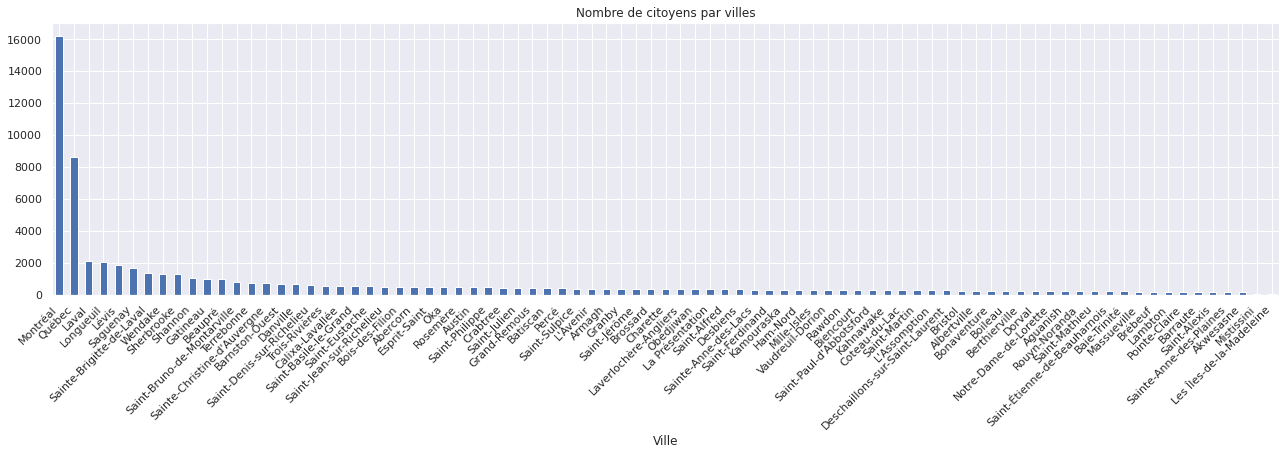

In [ ]:
df['city_name'].value_counts(dropna=True).plot(kind='bar',orientation=u'vertical',figsize=(22,5),title="Nombre de citoyens par villes",xlabel="Ville")
plt.xticks(rotation=45, ha='right')
plt.show()

### Nombre de citoyens intérrogé par jour

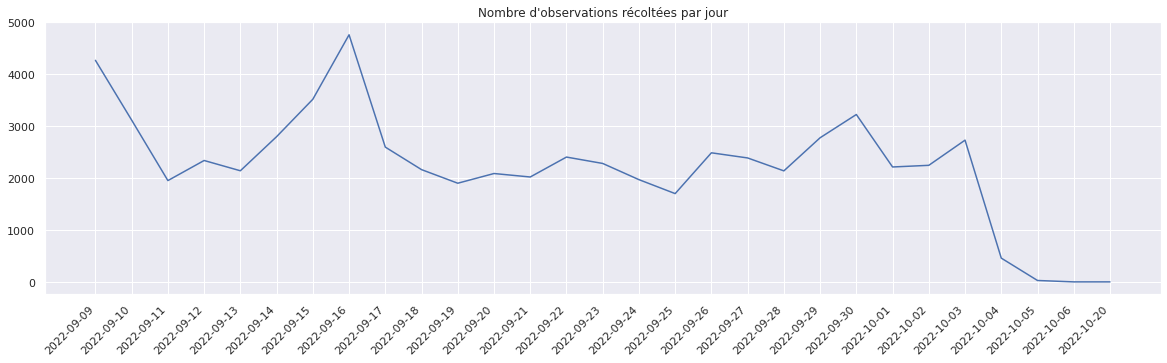

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df['time'].value_counts().sort_index())
plt.xticks(rotation=45, ha='right')
plt.title("Nombre d'observations récoltées par jour")
plt.show()

### Quel est le revenu moyen de votre ménage, avant impôts?

In [ ]:
none = df.loc[df["ses_income_None"] == 1].count()[0]
to30 = df.loc[df["ses_income_i1to30"] == 1].count()[0]
to60 = df.loc[df["ses_income_i31to60"] == 1].count()[0]
to90 = df.loc[df["ses_income_i61to90"] == 1].count()[0]
to110 = df.loc[df["ses_income_i91to110"] == 1].count()[0]
to150 = df.loc[df["ses_income_i111to150"] == 1].count()[0]
to200 = df.loc[df["ses_income_i151to200"] == 1].count()[0]
toInf = df.loc[df["ses_income_i201toInf"] == 1].count()[0]

salary = [none, to30, to60, to90, to110, to150, to200, toInf]
index = ["None", "1 to 30", "31 to 60", "61 to 90", "91 to 110", "111 to 150", "151 to 200", "200 and more"]

plt.figure(figsize=(12,6))
plt.bar(range(len(salary)), salary, align='center')
plt.xticks(range(len(index)), index, size='small')
plt.xlabel("Tranche de revenu")
plt.ylabel("Montant en $")
plt.title("Revenu moyen avant impôts")
plt.show()

valeurs de y + 5 circonscriptions les plus peuplés

In [22]:
print(df['correct_prediction'])

1        1
2        1
3        0
5        1
6        1
        ..
64733    1
64734    0
64736    1
64742    1
64743    0
Name: correct_prediction, Length: 30641, dtype: int64


In [60]:
df_riding = df.iloc[:,163:288]
population = dict()
for c in df_riding.columns:
  population[c] = df.loc[df[c] == 1].count()[0]
population = {k: v for k, v in sorted(population.items(), key=lambda item: item[1], reverse=True)}
print(population)

{'riding_Taschereau': 1237, 'riding_Jean Talon': 881, 'riding_Gouin': 827, 'riding_Laurier Dorion': 704, 'riding_Mercier': 697, 'riding_Jean Lesage': 682, 'riding_Hochelaga Maisonneuve': 662, 'riding_Rosemont': 609, 'riding_Chauveau': 606, 'riding_Sherbrooke': 602, 'riding_Montmorency': 571, 'riding_Vanier Les Rivières': 557, 'riding_Louis Hébert': 546, 'riding_Sainte Marie Saint Jacques': 531, 'riding_La Peltrie': 522, 'riding_Charlesbourg': 517, 'riding_Maurice Richard': 513, 'riding_Verdun': 510, 'riding_Saint Henri Sainte Anne': 505, 'riding_Chutes de la Chaudière': 474, 'riding_Lévis': 408, 'riding_Montarville': 367, 'riding_Charlevoix Côte de Beaupré': 366, 'riding_Mont Royal Outremont': 344, 'riding_Richmond': 344, 'riding_Saint François': 325, 'riding_Hull': 323, 'riding_Bourget': 313, 'riding_Chicoutimi': 297, 'riding_Trois Rivières': 286, 'riding_Borduas': 283, 'riding_Laporte': 278, 'riding_Portneuf': 276, 'riding_Taillon': 272, 'riding_Jonquière': 266, 'riding_Chambly': 262

In [ ]:
y_total = []
for key, val in population.items():
  y_per_riding = []
  for i in range(len(df)):
    if df[key][i] == 1:
      y_per_riding.append(df['correct_prediction'][i])  
  y_total.append(y_per_riding)

In [127]:
cpt = 0
ratio = []
for val in y_total:
  ratio.append(sum(val) / len(val))
  print("{} : {} ".format(list(population.keys())[cpt],val))
  cpt += 1


riding_Taschereau : [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1

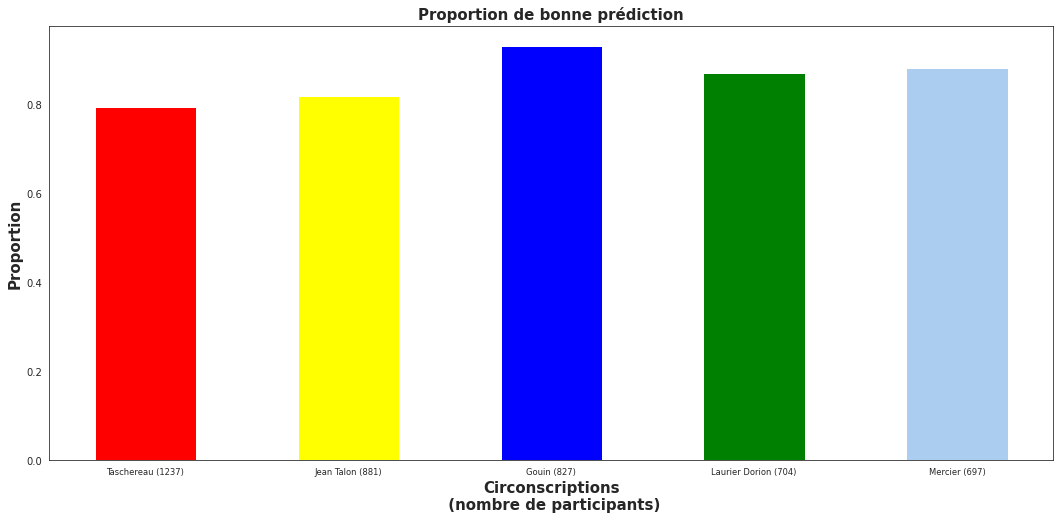

In [126]:
circ = ['Taschereau (1237)','Jean Talon (881)', 'Gouin (827)', 'Laurier Dorion (704)', 'Mercier (697)']
plt.figure(figsize=(18,8))
plt.bar(range(len(ratio)), ratio, align='center', width= 0.5, color=('red','yellow','blue','green','#abcdef'))
plt.xticks(range(len(circ)), circ, size='small')
plt.xlabel("Circonscriptions\n (nombre de participants)", fontdict = {'fontweight':'bold','fontsize':'15'})
plt.ylabel("Proportion", fontdict = {'fontweight':'bold','fontsize':'15'})
plt.title("Proportion de bonne prédiction",fontdict = {'fontweight':'bold','fontsize':'15'})
plt.savefig("proportion.svg")
plt.show()

In [2]:
print(ratio)

NameError: ignored

In [ ]:
!pip install mycolorpy

In [1]:
from mycolorpy import colorlist as mcp
import numpy as np
color1=mcp.gen_color(cmap="winter",n=125)
print(color1)

ModuleNotFoundError: ignored

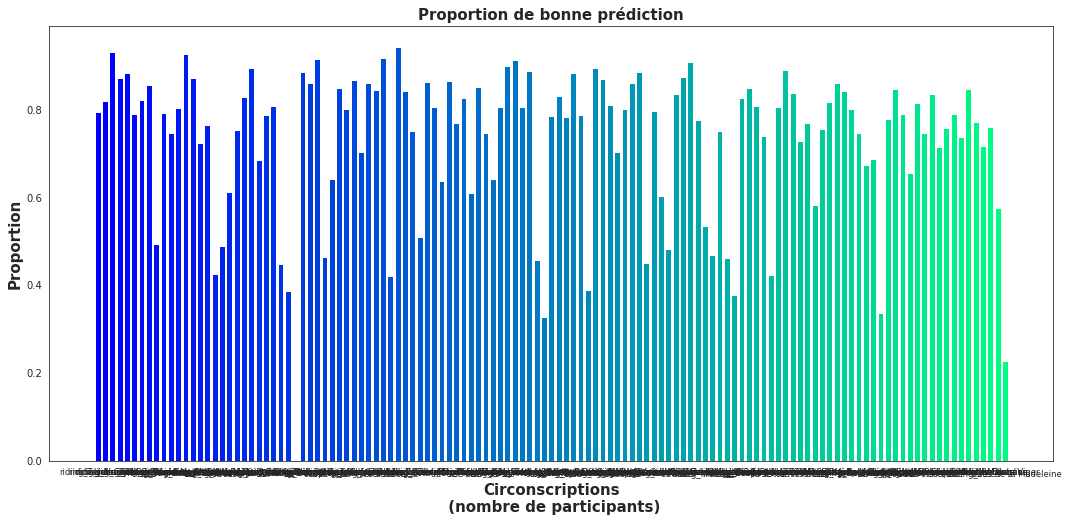

In [144]:
circ = ['Taschereau (1237)','Jean Talon (881)', 'Gouin (827)', 'Laurier Dorion (704)', 'Mercier (697)']
plt.figure(figsize=(18,8))
plt.bar(range(len(ratio)), ratio, align='center', color=color1)
plt.xticks(range(len(ratio)), list(population.keys()), size='small')
plt.xlabel("Circonscriptions\n (nombre de participants)", fontdict = {'fontweight':'bold','fontsize':'15'})
plt.ylabel("Proportion", fontdict = {'fontweight':'bold','fontsize':'15'})
plt.title("Proportion de bonne prédiction",fontdict = {'fontweight':'bold','fontsize':'15'})
#plt.savefig("proportion.svg")
plt.show()